### References

- https://adversarial-ml-tutorial.org/adversarial_examples/
- https://arxiv.org/pdf/1905.02175.pdf

In [1]:
import tensorflow as tf
from tensorflow import keras as K
import tensorflow_datasets as tfds

import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import time

In [8]:
def normalize(img, label):
    return img / 255, label

def make_tf_data(raw_ds):
    ds = raw_ds.map(normalize)
    return ds

In [9]:
def build_cnn_model(n_layers, n_filters, kernel_size=3, n_classes=10, model_name='basic_cnn'):
    """Builds basic CNN model for adversarial training; will need to be refactored
    non-using default train setup"""
    input_layer = tf.keras.layers.Input(shape=(28,28,1))
    
    # Add basic convolutional_layer
    hidden = tf.keras.layers.Conv2D(n_filters, kernel_size=3, strides=2, activation = 'relu')(input_layer)
    # Add single dense, non-linear layer
    hidden = tf.keras.layers.Flatten()(hidden)
    hidden = tf.keras.layers.Dense(16, activation = 'relu')(hidden)
    output = tf.keras.layers.Dense(n_classes, activation='softmax')(hidden) # softmax since multiclass class. problem
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [10]:
train_ds = tfds.load('mnist', split='train', shuffle_files=True, as_supervised=True, batch_size=32)
test_ds = tfds.load('mnist', split='test', shuffle_files=True, as_supervised=True, batch_size=32)

train_ds = make_tf_data(train_ds)
test_ds = make_tf_data(test_ds)

### Train robust model resistant to FGSM attacks

In [11]:
@tf.function
def fgsm_attack(model, X, y, epsilon=0.1):
    delta = tf.zeros_like(X)
    
    # use GradientTape to perform autodiff
    with tf.GradientTape() as tape:
        # specifically 'watch' delta
        # see here: https://www.tensorflow.org/guide/autodiff
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y, model(X + delta))
    delta = tf.sign(tape.gradient(loss, delta)) * epsilon
    return delta

In [12]:
@tf.function
def onestep_pgd_linf(model, X, y, epsilon, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y, model(X + delta))

    delta = tf.clip_by_value(delta + alpha*tf.sign(tape.gradient(loss, delta)), -epsilon, epsilon)
    
    return delta

def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = tf.zeros_like(X)
    for t in range(num_iter):
        delta = onestep_pgd_linf(model, X, y, epsilon, alpha, delta)
    return delta

In [28]:
def norm(Z):
    """Compute norms over all but the first dimension"""
    return tf.norm(Z[0,:,:,:])

# PGD L2 for Robustifying #
def single_pgd_step_robust(model, X, y, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.MeanSquaredError()(y, model(X + delta)) # comparing to robust model representation layer
        
    grad = tape.gradient(loss, delta)
    delta -= alpha*grad / norm(grad) # normalized gradient step
    delta = tf.math.minimum(tf.math.maximum(delta, -X), 1-X) # clip X+delta to [0,1]
    
    return delta, loss

@tf.function
def pgd_l2_robust(model, X, y, alpha, num_iter, bounded=False, epsilon=0, example=False):
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = single_pgd_step_robust(model, X, y, alpha, delta)
        if bounded:
            delta *= epsilon / tf.clip_by_value(norm(delta), epsilon, np.inf)
            # No epsilon bound here
    #         delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon) 
            # I think tensorflow does this automatically
#             delta.grad.zero_()

    if example:
        print(loss)
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

# PGD L2 for Adversarial Examples #
def single_pgd_step_adv(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()(y, model(X + delta)) # comparing to label for original data point

    grad = tape.gradient(loss, delta)
    delta += alpha*grad / norm(grad) # normalized gradient step
    delta = tf.math.minimum(tf.math.maximum(delta, -X), 1-X) # clip X+delta to [0,1]
    delta *= epsilon / tf.clip_by_value(norm(delta), epsilon, np.inf)
    
    return delta, loss

@tf.function
def pgd_l2_adv(model, X, y, alpha, num_iter, epsilon=0, example=False):
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = single_pgd_step_adv(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

2021-12-01 13:06:40.079718: W tensorflow/core/kernels/data/cache_dataset_ops.cc:798] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


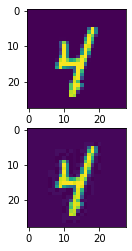

In [18]:
test_model = build_cnn_model(1, 32)
for b in train_ds.unbatch():
    X, y = b
    X = tf.expand_dims(X, 0)
    delta = fgsm_attack(test_model, X, y, 0.02)
    Xd = X + delta
    break
fig, axs = plt.subplots(2)
axs[0].imshow(np.squeeze(X))
axs[1].imshow(np.squeeze(Xd))

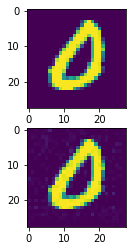

In [30]:
test_model = build_cnn_model(1, 32)
for b in train_ds.unbatch():
    X, y = b
    X = tf.expand_dims(X, 0)
    delta = pgd_l2_adv(test_model, X, y, epsilon=0.5, alpha=0.1, num_iter=50)
#     delta = pgd_linf(test_model, X, y, epsilon=0.1, alpha=1e-2, num_iter=50)

    Xd = X + delta
    break
fig, axs = plt.subplots(2)
axs[0].imshow(np.squeeze(X))
axs[1].imshow(np.squeeze(Xd))

## Standard training with adversary in test

In [31]:
EPOCHS = 5

# Build model again, leaving out summary
model = build_cnn_model(1, 32)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

for n in range(EPOCHS):
    
    t = time.time()
    train_losses = []
    train_accs = []
    for b in train_ds:
        X, y = b

        l, acc = model.train_on_batch(X, y)
        train_losses.append(l)
        train_accs.append(acc)

    test_losses = []
    test_accs = []
    for vb in test_ds:
        Xtest, ytest = vb
        
        # Apply attack to get delta
        # Importantly, only attack at test time rather than during training
#         delta = fgsm_attack(model, Xtest, ytest)
#         delta = pgd_linf(model, Xtest, ytest, epsilon=0.1, alpha=1e-1, num_iter=40)
        delta = pgd_l2_adv(model, Xtest, ytest, epsilon=0.5, alpha=0.1, num_iter=50)
        Xdtest = Xtest + delta
        
        l, acc = model.test_on_batch(Xdtest, ytest)
        test_losses.append(l)
        test_accs.append(acc)
    
    train_loss = sum(train_losses) / len(train_losses)
    train_acc = sum(train_accs) / len(train_accs)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
        
    print(f"Epoch {n}/{EPOCHS}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

Epoch 0/5, Time: 29.21 -- Train Loss: 0.29, Train Acc: 0.91, Test Loss: 24.55, Test Acc: 0.48
Epoch 1/5, Time: 20.57 -- Train Loss: 0.11, Train Acc: 0.97, Test Loss: 29.96, Test Acc: 0.49
Epoch 2/5, Time: 20.03 -- Train Loss: 0.08, Train Acc: 0.98, Test Loss: 34.71, Test Acc: 0.49
Epoch 3/5, Time: 21.22 -- Train Loss: 0.06, Train Acc: 0.98, Test Loss: 39.60, Test Acc: 0.50
Epoch 4/5, Time: 20.49 -- Train Loss: 0.05, Train Acc: 0.99, Test Loss: 44.43, Test Acc: 0.50


## Train Robust Model (adversaries in training)

In [32]:
EPOCHS = 5

# Build model again, leaving out summary
robust_model = build_cnn_model(1, 32)

robust_model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

for n in range(EPOCHS):
    t = time.time()
    train_losses = []
    train_accs = []
    for b in train_ds:
        X, y = b
        
        # Apply attack during training as well as testing
#         delta = fgsm_attack(robust_model, X, y, 0.02)
        delta = pgd_l2_adv(robust_model, X, y, epsilon=0.5, alpha=1e-1, num_iter=50)
#         delta = pgd_linf(robust_model, X, y, epsilon=0.1, alpha=1e-1, num_iter=40)
        Xd = X + delta

        l, acc = robust_model.train_on_batch(Xd, y)
        train_losses.append(l)
        train_accs.append(acc)

    test_losses = []
    test_accs = []
    for vb in test_ds:
        Xtest, ytest = vb
        
        # Apply attack to get delta
        # Importantly, only attack at test time rather than during training
        #delta = fgsm_attack(model, Xtest, ytest)
        Xdtest = Xtest #+ delta
        
        l, acc = robust_model.test_on_batch(Xdtest, ytest)
        test_losses.append(l)
        test_accs.append(acc)
    
    train_loss = sum(train_losses) / len(train_losses)
    train_acc = sum(train_accs) / len(train_accs)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
        
    print(f"Epoch {n}/{EPOCHS}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

Epoch 0/5, Time: 68.08 -- Train Loss: 1.35, Train Acc: 0.66, Test Loss: 0.53, Test Acc: 0.92
Epoch 1/5, Time: 69.47 -- Train Loss: 1.23, Train Acc: 0.71, Test Loss: 0.50, Test Acc: 0.93
Epoch 2/5, Time: 67.97 -- Train Loss: 1.21, Train Acc: 0.71, Test Loss: 0.48, Test Acc: 0.93
Epoch 3/5, Time: 65.55 -- Train Loss: 1.19, Train Acc: 0.72, Test Loss: 0.46, Test Acc: 0.93
Epoch 4/5, Time: 64.16 -- Train Loss: 1.18, Train Acc: 0.72, Test Loss: 0.45, Test Acc: 0.94


## Generate robust version of original data

Use robust NN to create a robustifier

In [37]:
# Grab representation layer from robust model
representation = robust_model.layers[-2]
robustifier = tf.keras.Model(inputs = robust_model.input, outputs = representation.output)

In [38]:
unbatched_train = train_ds.unbatch()

In [39]:
last_img = list(unbatched_train.as_numpy_iterator())[-1][0]

In [40]:
robust_train = []
orig_labels = []
iters = 100
example = False
# initialize random image as last image in dataset
rand_img = last_img
rand_img = tf.expand_dims(rand_img, axis=0)

start_time = time.time()
for i, (img, label) in enumerate(unbatched_train):
    # data point we want to get robust features for
    curr_img = tf.expand_dims(img, axis=0)
    goal_representation = robustifier(curr_img)
    
    
    learned_delta = pgd_l2_robust(robustifier, rand_img, goal_representation, alpha=0.1, num_iter=iters)
    robust_update = (rand_img + learned_delta)[0,:,:,:] # trim off first dim
    robust_train.append(robust_update)
    orig_labels.append(label)
    
    if i%1000 == 0:
        elapsed = time.time() - start_time
        print(f'Robustified {i} images in {elapsed:0.3f} seconds')
        start_time = time.time()
    
    # reset random image to be previous image
    rand_img = curr_img.numpy()

Robustified 0 images in 9.128 seconds
Robustified 1000 images in 9.596 seconds
Robustified 2000 images in 9.142 seconds
Robustified 3000 images in 10.054 seconds
Robustified 4000 images in 9.471 seconds
Robustified 5000 images in 9.065 seconds
Robustified 6000 images in 9.082 seconds
Robustified 7000 images in 8.793 seconds
Robustified 8000 images in 8.955 seconds
Robustified 9000 images in 8.830 seconds
Robustified 10000 images in 8.753 seconds
Robustified 11000 images in 8.286 seconds
Robustified 12000 images in 8.497 seconds
Robustified 13000 images in 8.611 seconds
Robustified 14000 images in 8.930 seconds
Robustified 15000 images in 8.589 seconds
Robustified 16000 images in 8.527 seconds
Robustified 17000 images in 8.867 seconds
Robustified 18000 images in 8.802 seconds
Robustified 19000 images in 8.529 seconds
Robustified 20000 images in 8.777 seconds
Robustified 21000 images in 8.650 seconds
Robustified 22000 images in 8.417 seconds
Robustified 23000 images in 8.402 seconds
Robu

### Aside to see adversarial examples

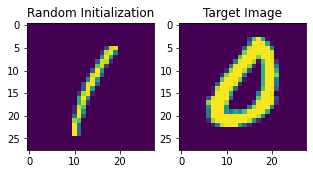

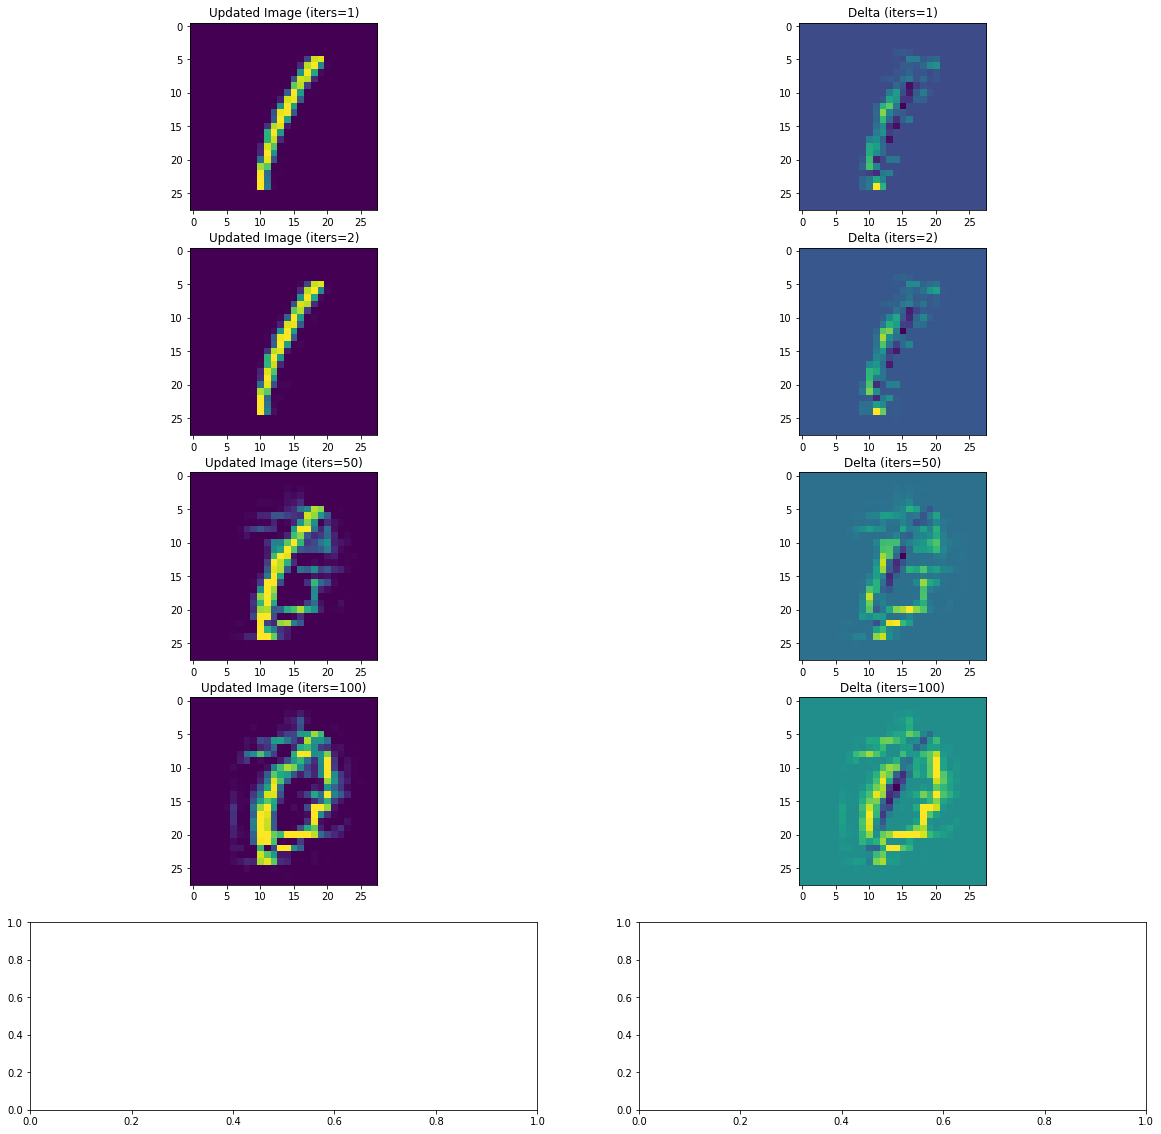

In [47]:
example = True
for img, label in unbatched_train:
    # data point we want to get robust features for
    curr_img = tf.expand_dims(img, axis=0)
    goal_representation = robustifier(curr_img)
    
    # starting point for PGD is another point in the dataset
    rand_img = next(unbatched_train.shuffle(int(1e6)).take(1).as_numpy_iterator())[0]
    rand_img = tf.expand_dims(rand_img, axis=0)
    
    fig, starts = plt.subplots(1,2,figsize=(5,5))
    starts = starts.flatten()
    starts[0].imshow(rand_img[0,:,:,:].numpy())
    starts[0].set_title('Random Initialization')
    starts[1].imshow(curr_img[0,:,:,:])
    starts[1].set_title('Target Image')
    
    fig, axs = plt.subplots(5, 2, figsize=(20,20))
    for i, iters in enumerate([1,2,50,100]):
        learned_delta = pgd_l2_robust(robustifier, rand_img, goal_representation, alpha=0.1, num_iter=iters, example=True)
        robust_update = (rand_img + learned_delta)[0,:,:,:] # trim off first dim
    
        axs[i][0].imshow(robust_update)
        axs[i][0].set_title(f'Updated Image (iters={iters})')
        axs[i][1].imshow(learned_delta[0,:,:,:])
        axs[i][1].set_title(f'Delta (iters={iters})')
        
    break

## Try training on robust data set and testing with adversarial examples

In [59]:
orig_labels[-5].numpy()

7

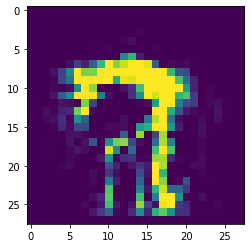

In [58]:
plt.imshow(robust_train[-5].numpy())

In [43]:
robust_ds = tf.data.Dataset.from_tensor_slices((robust_train, orig_labels)).batch(32)

In [62]:
EPOCHS = 5

# Build model again, leaving out summary
model = build_cnn_model(1, 32)

model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

for n in range(EPOCHS):
    
    t = time.time()
    train_losses = []
    train_accs = []
    for b in robust_ds:
        X, y = b

        l, acc = model.train_on_batch(X, y)
        train_losses.append(l)
        train_accs.append(acc)

    test_losses = []
    test_accs = []
    for vb in test_ds:
        Xtest, ytest = vb
        
        # Apply attack to get delta
        # Importantly, only attack at test time rather than during training
#         delta = fgsm_attack(model, Xtest, ytest)
        delta = pgd_l2_adv(model, Xtest, ytest, epsilon=0.1, alpha=1e-2, num_iter=10)
        Xdtest = Xtest + delta
        
        l, acc = model.test_on_batch(Xdtest, ytest)
        test_losses.append(l)
        test_accs.append(acc)
    
    train_loss = sum(train_losses) / len(train_losses)
    train_acc = sum(train_accs) / len(train_accs)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
        
    print(f"Epoch {n}/{EPOCHS}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

Epoch 0/5, Time: 20.98 -- Train Loss: 0.39, Train Acc: 0.88, Test Loss: 12.43, Test Acc: 0.63
Epoch 1/5, Time: 12.96 -- Train Loss: 0.25, Train Acc: 0.92, Test Loss: 14.24, Test Acc: 0.62
Epoch 2/5, Time: 13.98 -- Train Loss: 0.23, Train Acc: 0.93, Test Loss: 17.54, Test Acc: 0.60
Epoch 3/5, Time: 13.89 -- Train Loss: 0.21, Train Acc: 0.93, Test Loss: 21.07, Test Acc: 0.59
Epoch 4/5, Time: 14.02 -- Train Loss: 0.20, Train Acc: 0.94, Test Loss: 25.19, Test Acc: 0.58
